# Practice PS07: Outlier analysis

<font size="+2" color="blue">Additional results: faster method to find all depths</font>

*Note: Throughout the analysis, I employed the normal function to identify all depths. The improved version is commented out.*

Author: <font color="blue">Àlex Montoya Pérez</font>

E-mail: <font color="blue">alex.montoya.01@estudiant.upf.edu</font>

Date: <font color="blue">11/11/2023</font>

In [82]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
import io
import random
import numpy as np

# **Google Colaboratory Setup & Imports**

In order to develop this laboratory, I used Google Colaboratory, since I have worked with different files I had to set up the environment as follows:


1.   Importing the drive module from the google.colab package.
2.   Mounting the Google Drive at the specified path (/content/drive).
3.   Changing the current working directory to the directory where I have all needed data /content/drive/MyDrive/MineriaDadesMasives/Labs/.

Verify that we are in the correct directory:


4.   Printing the current working directory path using !pwd.
5.   Listing the contents of the current directory using !ls.

In [83]:
from google.colab import drive
drive.mount('/content/drive')
#Here is how to change current working directory
#By default the current working directory is /content
%cd /content/drive/MyDrive/MineriaDadesMasives/Labs/
#Print path and content of the current directory
!pwd
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/MineriaDadesMasives/Labs
/content/drive/MyDrive/MineriaDadesMasives/Labs
data					ps06_item_based_recsys_242873.ipynb
old					ps07_outlier_analysis.ipynb
ps01_02_data_preparation_242873.ipynb	ps08_data_streams.ipynb
ps03_near_duplicates.ipynb		ps09_forecasting.ipynb
ps04_association_rules.ipynb		README.md
ps05_content_based_recsys_242873.ipynb


# 1. Dataset

In [84]:
# LEAVE AS-IS

df = pd.read_csv('data/annthyroid.csv', sep=',')

# Replace the "label" column by an "abnormal" column
df['result'] = df['label'].apply(lambda x: 'abnormal' if x == 1 else 'normal')
df.drop(columns=['label'], inplace=True)

## Number and percentages of patients in each group.

In [85]:
display(df.head(10))
number_patients = len(df)
print('Total number of patients: ', number_patients)

normal = len(df.loc[df['result'].isin(['normal'])])/len(df['result'])
print('percentage of patients with normal thyroid: ', normal)

abnormal = len(df.loc[df['result'].isin(['abnormal'])])/len(df['result'])
print('percentage of patients with abnormal thyroid: ', abnormal)

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


Total number of patients:  7200
percentage of patients with normal thyroid:  0.9258333333333333
percentage of patients with abnormal thyroid:  0.07416666666666667


## 10 normal exams and their centroid

In [86]:
normal = df.loc[df['result'].isin(['normal'])]
means_normal = normal[['f1', 'f2','f3', 'f4', 'f5', 'f6']].mean()
print(means_normal)
display(normal.head(10))

f1    0.518314
f2    0.002098
f3    0.020384
f4    0.112193
f5    0.097705
f6    0.116132
dtype: float64


,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.015,0.120,0.082,0.146,normal
1,0.24,0.00025,0.030,0.143,0.133,0.108,normal
2,0.47,0.00190,0.024,0.102,0.131,0.078,normal
3,0.64,0.00090,0.017,0.077,0.090,0.085,normal
4,0.23,0.00025,0.026,0.139,0.090,0.153,normal
5,0.69,0.00025,0.016,0.086,0.070,0.123,normal
6,0.85,0.00025,0.023,0.128,0.104,0.121,normal
7,0.48,0.00208,0.020,0.086,0.078,0.110,normal
8,0.67,0.00130,0.024,0.087,0.109,0.080,normal
9,0.76,0.00010,0.029,0.124,0.128,0.097,normal


## first 10 abnormal exams and their centroid.

In [87]:
abnormal = df.loc[df['result'].isin(['abnormal'])]
means_abnormal = abnormal[['f1', 'f2','f3', 'f4', 'f5', 'f6']].mean()
print(means_abnormal)
display(abnormal.head(10))

f1    0.548034
f2    0.039363
f3    0.014891
f4    0.074940
f5    0.099500
f6    0.076803
dtype: float64


,f1,f2,f3,f4,f5,f6,result
10,0.62,0.01100,0.0080,0.0730,0.074,0.0980,abnormal
19,0.50,0.06100,0.0096,0.0130,0.116,0.0110,abnormal
27,0.78,0.02500,0.0090,0.0500,0.084,0.0600,abnormal
43,0.61,0.00979,0.0040,0.0810,0.064,0.1260,abnormal
84,0.56,0.00820,0.0200,0.0660,0.094,0.0700,abnormal
105,0.73,0.04700,0.0110,0.0520,0.090,0.0580,abnormal
115,0.43,0.07000,0.0050,0.0029,0.104,0.0028,abnormal
116,0.42,0.03100,0.0080,0.0130,0.119,0.0110,abnormal
145,0.78,0.00630,0.0110,0.0560,0.086,0.0650,abnormal
147,0.53,0.02500,0.0040,0.0390,0.061,0.0640,abnormal


 **Based only on the means, which features do you think could be useful for differentiating between normal and abnormal thyroids? Why?**

A higher value in f2 could prove beneficial. Therefore, a larger f2 value suggests proximity to an abnormal outcome.

Similarly, a higher value in f4 could be advantageous. Thus, a larger f4 value indicates proximity to a normal outcome.

Likewise, a higher value in f6 could be valuable. Consequently, a larger f6 value suggests proximity to a normal outcome.

I believe these indicators are useful as they highlight the significant differences in means between normal and abnormal cases.


## Scatter Matrix

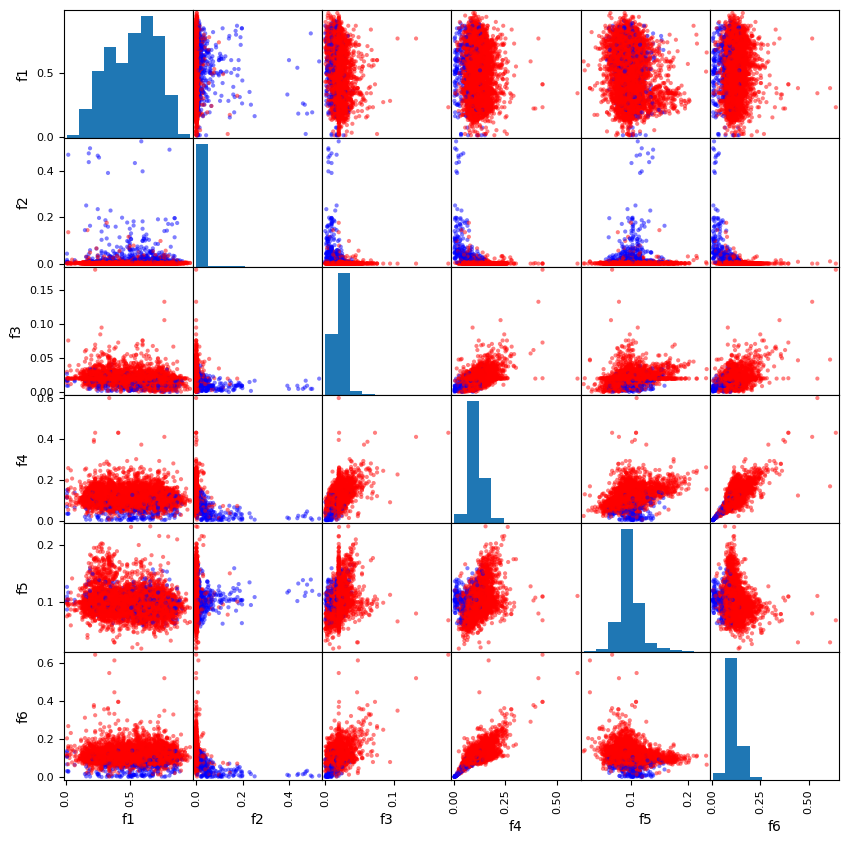

In [88]:
color_code = {'abnormal': 'blue', 'normal': 'red'}

colors = df['result'].apply(lambda x: color_code[x])

figure = pd.plotting.scatter_matrix(df, c=colors, figsize = (10,10))

**What are the differences you can appreciate?**

In f1, no significant differences are observed when comparing it with other features.

For f2, notable values of abnormal results are evident in comparisons with all features, whereas normal results exhibit values closely clustered around 0.

Concerning f3 and f4, in contrast to f1, f3/f4/f5, and f6, larger values are observed for normal results compared to abnormal ones. However, examining f4/f3-f2 reveals a distinct pattern, where the blue values are higher along the f2 axis and approach 0 on the f4 axis.

In the case of f5, abnormal results closely approach 0 on the f3, f4, and f6 axes, while normal values are larger but not excessively so. Similar observations apply to the f5-f2 comparison, echoing what was noted for f2.

Upon inspecting f6, higher values are noticeable for abnormal results, while normal results remain close to 0 on the f6 axis.

# 1. Create isolation tree

## 1.1. Random dimension and random split

###Pick Random Dimension

In [89]:
def pick_random_dimension(df, columns_to_ignore):
    valid_dimensions = [col for col in df.columns if col not in columns_to_ignore]

    if not valid_dimensions:
        raise ValueError("No valid dimensions available")

    return random.choice(valid_dimensions)


In [90]:
#Calls to the function
print(pick_random_dimension(normal, ['result']))
pick_random_dimension(normal, ['result'])

f6


'f1'

### Pick Random Split

In [91]:
def pick_random_split(df, dimension):
    min_value = np.min(df[dimension])
    max_value = np.max(df[dimension])

    # Generate a random split point within the range [min_value, max_value]
    random_split = np.random.uniform(min_value, max_value)

    return random_split

In [92]:
display(pick_random_split(normal, pick_random_dimension(normal, ['result'])))
pick_random_split(normal, pick_random_dimension(normal, ['result']))

0.07606164456807324

0.5634678139753494

## 1.2. Implement split data into two

In [93]:
def split_dataset(df, dimension, split):
    return df[df[dimension] <= split], df[df[dimension] > split]

### Split Dataset

In [94]:
(left, right) = split_dataset(df, 'f1', 0.5)

#### Left Piece

In [95]:
display(left)
print('minimum and maximum value of left: ', np.min(left['f1']), 'and', np.max(left['f1']))

,f1,f2,f3,f4,f5,f6,result
1,0.24,0.00025,0.0300,0.14300,0.133,0.10800,normal
2,0.47,0.00190,0.0240,0.10200,0.131,0.07800,normal
4,0.23,0.00025,0.0260,0.13900,0.090,0.15300,normal
7,0.48,0.00208,0.0200,0.08600,0.078,0.11000,normal
11,0.18,0.00010,0.0230,0.09800,0.085,0.11500,normal
...,...,...,...,...,...,...,...
7171,0.46,0.00170,0.0201,0.13500,0.104,0.12900,normal
7179,0.33,0.00230,0.0201,0.07700,0.083,0.09300,normal
7180,0.30,0.00170,0.0230,0.08300,0.081,0.10200,normal
7192,0.45,0.00077,0.0201,0.11329,0.096,0.11776,normal


minimum and maximum value of left:  0.01 and 0.5


#### Right Piece

In [96]:
display(right)
print('minimum and maximum value of right: ', np.min(right['f1']), 'and', np.max(right['f1']))

,f1,f2,f3,f4,f5,f6,result
0,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
3,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
5,0.69,0.00025,0.0160,0.086,0.070,0.1230,normal
6,0.85,0.00025,0.0230,0.128,0.104,0.1210,normal
8,0.67,0.00130,0.0240,0.087,0.109,0.0800,normal
...,...,...,...,...,...,...,...
7194,0.79,0.00490,0.0201,0.077,0.082,0.0940,normal
7195,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal


minimum and maximum value of right:  0.51 and 0.97


## 1.3. Create one isolation tree

In [97]:
# LEAVE AS-IS

dfi = df.copy()
dfi.insert(0, 'id', [("P%.4d" % x) for x in range(1, 1 + len(df))])
dfi

,id,f1,f2,f3,f4,f5,f6,result
0,P0001,0.73,0.00060,0.0150,0.120,0.082,0.1460,normal
1,P0002,0.24,0.00025,0.0300,0.143,0.133,0.1080,normal
2,P0003,0.47,0.00190,0.0240,0.102,0.131,0.0780,normal
3,P0004,0.64,0.00090,0.0170,0.077,0.090,0.0850,normal
4,P0005,0.23,0.00025,0.0260,0.139,0.090,0.1530,normal
...,...,...,...,...,...,...,...,...
7195,P7196,0.59,0.00250,0.0208,0.079,0.099,0.0800,normal
7196,P7197,0.51,0.10600,0.0060,0.005,0.089,0.0055,abnormal
7197,P7198,0.51,0.00076,0.0201,0.090,0.067,0.1340,normal
7198,P7199,0.35,0.00280,0.0201,0.090,0.089,0.1010,normal


### Isolation Tree

In [98]:
def isolation_tree(data, columns_to_ignore, min_items):
    tree = {}
    if len(data) <= min_items:
        return {"contents": data}
    else:
        # Select a random dimension to split the data
        dimension = pick_random_dimension(data, columns_to_ignore)
        # Pick a random split point along the selected dimension
        split = pick_random_split(data, dimension)
        # Split the dataset into two based on the chosen dimension and split point
        (left_a, right_a) = split_dataset(data, dimension, split)
         # Recursively build the left subtree by calling the isolation_tree function on the left dataset
        left = isolation_tree(left_a, columns_to_ignore, min_items)
        # Recursively build the right subtree by calling the isolation_tree function on the right dataset
        right = isolation_tree(right_a, columns_to_ignore, min_items)
        # Construct the current tree node with information about the split
        tree = {"left": left, "right": right, "dimension": dimension, "split": split}
        return tree

In [99]:
# LEAVE AS-IS

mytree = isolation_tree(dfi, ['id', 'result'], 2000)

In [100]:
# LEAVE AS-IS

class tree_drawing(object):
    def __init__(self, value, left=None, right=None):
        self.value = value
        self.left = left
        self.right = right

    def __str__(self, label='', level=0):
        ret = "-" * level + label + ":" + repr(self.value)+"\n"
        if self.left:
            ret += self.left.__str__("<", level+1)
        if self.right:
            ret += self.right.__str__(">", level+1)
        return ret

    def __repr__(self):
        return self.value

def tree_to_nodes(tree):
    if 'contents' in tree:
        data = tree['contents']
        normal_count = len(data[data['result'] == 'normal'])
        abnormal_count = len(data[data['result'] == 'abnormal'])
        description = "external node: %d normal + %d abnormal" % (normal_count, abnormal_count)
        return tree_drawing(description)
    else:
        left = tree['left']
        right = tree['right']
        description = 'internal node: ' + tree['dimension'] + ' <= ' + ("%.2f" % tree['split'])
        n = tree_drawing(description, tree_to_nodes(left), tree_to_nodes(right) )
        return n

In [101]:
print(tree_to_nodes(mytree))

:'internal node: f1 <= 0.34'
-<:'external node: 1490 normal + 94 abnormal'
->:'internal node: f2 <= 0.49'
--<:'internal node: f6 <= 0.46'
---<:'internal node: f4 <= 0.23'
----<:'internal node: f1 <= 0.78'
-----<:'internal node: f2 <= 0.17'
------<:'internal node: f5 <= 0.22'
-------<:'internal node: f1 <= 0.54'
--------<:'external node: 1861 normal + 127 abnormal'
-------->:'internal node: f1 <= 0.77'
---------<:'internal node: f6 <= 0.12'
----------<:'internal node: f2 <= 0.05'
-----------<:'internal node: f6 <= 0.05'
------------<:'external node: 11 normal + 15 abnormal'
------------>:'internal node: f6 <= 0.09'
-------------<:'external node: 248 normal + 81 abnormal'
------------->:'external node: 1572 normal + 105 abnormal'
----------->:'external node: 2 normal + 23 abnormal'
---------->:'external node: 875 normal + 18 abnormal'
--------->:'external node: 161 normal + 17 abnormal'
------->:'external node: 1 normal + 0 abnormal'
------>:'external node: 0 normal + 9 abnormal'
----->:

### Get Max Tree Depth

In [102]:
def get_max_tree_depth(tree):
    # Base case: if the tree is a leaf node, return depth 0
    if 'contents' in tree:
        return 0
    else:
        # Recursively calculate the depth of the left and right subtrees
        left_depth = get_max_tree_depth(tree['left'])
        right_depth = get_max_tree_depth(tree['right'])

        # Return the maximum depth among the left and right subtrees, plus 1 for the current level
        return max(left_depth, right_depth) + 1


#### Test

In [103]:
print("Maximum Tree Depth:" ,get_max_tree_depth(mytree))

Maximum Tree Depth: 13


# 2. Create isolation forests and find depth of items

## 2.1. Create an isolation forest

### Isolation Forest Function

In [104]:
def isolation_forest(dfi, columns_to_ignore, min_items, num_trees):
    returning = [dict() for x in range(num_trees)] #Create a dictionary
    #We do "num_trees" isolation trees
    for i in range(num_trees):
        returning[i] = isolation_tree(dfi, columns_to_ignore, min_items)
    return returning

In [105]:
# MODIFY IF YOU SEE THAT IT IMPROVES THE SEPARATION BETWEEN CLASSES

min_items = 50
num_trees = 20

In [106]:
# LEAVE AS-IS

myforest = isolation_forest(dfi, ['id', 'result'], min_items, num_trees)
print("The forest has %d trees" % len(myforest))

The forest has 20 trees


In [107]:
# Leave this code as-is

for i in range(0, 2):
    print("Tree number %d" % i)
    print(tree_to_nodes(myforest[i]))
    print()

Tree number 0
:'internal node: f4 <= 0.01'
-<:'external node: 1 normal + 23 abnormal'
->:'internal node: f3 <= 0.07'
--<:'internal node: f6 <= 0.14'
---<:'internal node: f6 <= 0.10'
----<:'internal node: f5 <= 0.10'
-----<:'internal node: f1 <= 0.82'
------<:'internal node: f3 <= 0.01'
-------<:'internal node: f5 <= 0.07'
--------<:'external node: 16 normal + 7 abnormal'
-------->:'external node: 36 normal + 13 abnormal'
------->:'internal node: f5 <= 0.05'
--------<:'external node: 2 normal + 0 abnormal'
-------->:'internal node: f6 <= 0.09'
---------<:'internal node: f6 <= 0.07'
----------<:'internal node: f4 <= 0.02'
-----------<:'external node: 2 normal + 2 abnormal'
----------->:'internal node: f4 <= 0.03'
------------<:'external node: 1 normal + 0 abnormal'
------------>:'internal node: f3 <= 0.04'
-------------<:'internal node: f6 <= 0.05'
--------------<:'external node: 14 normal + 16 abnormal'
-------------->:'internal node: f1 <= 0.50'
---------------<:'internal node: f6 <= 0

## 2.2. Find the average depth of an item

In [108]:
# LEAVE AS-IS

def find_element_depth_aux(tree, column_name, column_value, depth):

    if 'contents' in tree:
        # We are in a leaf node

        data = tree['contents']
        matching = data[data[column_name] == column_value]
        if len(matching) == 0:
            return None
        elif len(matching) > 1:
            print("Error: multiple elements match your search criterion")
            return None
        else:
            return depth
    else:
        # We are in an internal node

        in_left = find_element_depth_aux(tree['left'], column_name, column_value, depth+1)
        if in_left == None:
            in_right = find_element_depth_aux(tree['right'], column_name, column_value, depth+1)
            return in_right
        else:
            return in_left

def find_element_depth(tree, column_name, column_value):
    return find_element_depth_aux(tree, column_name, column_value, 0)

In [109]:
# LEAVE AS-IS

def print_sample_depths(df, sample_size, tested_tree):

    for result in ['normal', 'abnormal']:
        print("Depths for %s items" % result)

        sample = list(df[df['result'] == result]['id'].sample(sample_size))

        max_depth = get_max_tree_depth(tested_tree)
        for random_id in sample:
            print("- id=%s is at depth %d/%d" % (random_id, find_element_depth(tested_tree, "id", random_id), max_depth))


print("On shallow tree, having maximum depth %d" % get_max_tree_depth(mytree))
print_sample_depths(dfi, 5, mytree)
print()

print("On first tree of forest, having maximum depth %d" % get_max_tree_depth(myforest[0]))
print_sample_depths(dfi, 5, myforest[0])
print()


On shallow tree, having maximum depth 13
Depths for normal items
- id=P6181 is at depth 10/13
- id=P5878 is at depth 8/13
- id=P3739 is at depth 13/13
- id=P0574 is at depth 8/13
- id=P2008 is at depth 1/13
Depths for abnormal items
- id=P3098 is at depth 1/13
- id=P6627 is at depth 1/13
- id=P0430 is at depth 13/13
- id=P1058 is at depth 8/13
- id=P5782 is at depth 13/13

On first tree of forest, having maximum depth 29
Depths for normal items
- id=P4890 is at depth 10/29
- id=P0176 is at depth 21/29
- id=P1916 is at depth 22/29
- id=P1526 is at depth 8/29
- id=P7085 is at depth 20/29
Depths for abnormal items
- id=P1763 is at depth 13/29
- id=P6300 is at depth 6/29
- id=P5875 is at depth 16/29
- id=P4277 is at depth 13/29
- id=P0146 is at depth 17/29



In the shallow tree, both normal and abnormal items are found at different depths, but the maximum depth is relatively shallow (13).

In the first tree of the forest, with a much higher maximum depth (29), items exhibit a wider range of depths, reflecting the complexity and depth of the tree structure.

The variations in depth for both normal and abnormal items suggest that the decision boundaries within these trees are complex, with some items reaching deeper levels while others remain at shallower depths.

### Find average depth

In [110]:
def find_average_depth(forest, column_name, value):
    depths = [0]*len(forest)
    #For each forest we find the depth of the elements and store them in depths.
    for i in range(len(forest)):
        depths[i] = find_element_depth(forest[i], column_name, value)
    return sum(depths)/len(depths)


In [112]:
# LEAVE AS-IS

for result in ['normal', 'abnormal']:
    print("Average depths for %s items" % result)

    sample = list(dfi[dfi['result'] == result]['id'].sample(5))

    for random_id in sample:
        print("- id=%s is at average depth %.1f" % (random_id, find_average_depth(myforest, "id", random_id)))

    print()

Average depths for normal items
- id=P4557 is at average depth 12.8
- id=P6613 is at average depth 16.1
- id=P0441 is at average depth 34.5
- id=P6976 is at average depth 11.2
- id=P3366 is at average depth 11.6

Average depths for abnormal items
- id=P6669 is at average depth 16.8
- id=P0518 is at average depth 9.2
- id=P0965 is at average depth 9.2
- id=P1608 is at average depth 16.4
- id=P5857 is at average depth 21.4



**How would you make the "find_average_depth" function more efficient if you wanted to obtain the average depth of all elements?**

 I will suggest to avoid making separate passes through the forest for normal and abnormal items to calculate their average depths. Instead, we could average the depths of all elements in the dataset without distinguishing between normal or abnormal items. This can be achieved by considering the entire dataset in a single pass.

<font color='blue'>
<h2> Faster method for find_average_depth (Extra)
</font>

We can take advantage of vectorized operations provided by the NumPy library. This approach avoids explicit loops and is generally more efficient. Also, for the histograms, using the entire dataset instead of sampling will provide a more accurate representation of the distribution.

In [111]:
# def find_average_depth(forest, column_name, values):
#     total_depths = np.zeros(len(forest))
#     matching_counts = np.zeros(len(forest))

#     # Iterate over each tree in the forest
#     for i, tree in enumerate(forest):
#         # Find the depth of the element in the current tree
#         depths = find_element_depth(tree, column_name, values)

#         # Update total_depths and matching_counts using vectorized operations
#         matching_mask = depths != None
#         total_depths[i] = np.sum(depths[matching_mask])
#         matching_counts[i] = np.sum(matching_mask)

#     # Calculate the average depth using vectorized operations
#     average_depths = np.divide(total_depths, matching_counts, out=np.zeros_like(total_depths), where=matching_counts != 0)

#     # Calculate the overall average depth
#     overall_average_depth = np.mean(average_depths[matching_counts != 0])

#     return overall_average_depth

# Example usage:
# overall_average_depth = find_average_depth(my_forest, 'id', values)
# print("Overall Average Depth:", overall_average_depth)


# 3. Find the average depth of a sample of normal and abnormal points

## 3.1. Determine average depths

In [113]:
# LEAVE AS-IS

abnormal_point_ids = list(dfi[dfi['result'] == 'abnormal']['id'].sample(30))
normal_point_ids = list(dfi[dfi['result'] == 'normal']['id'].sample(30))

print("Normal point sample ids   : %s" % normal_point_ids)
print("Abnormal point sample ids : %s" % abnormal_point_ids)

Normal point sample ids   : ['P6135', 'P1504', 'P2522', 'P2056', 'P0964', 'P3692', 'P1893', 'P4237', 'P5575', 'P0515', 'P1775', 'P2308', 'P0282', 'P0879', 'P6419', 'P6994', 'P6007', 'P2055', 'P5515', 'P0527', 'P6190', 'P3719', 'P6760', 'P1219', 'P1434', 'P0330', 'P3714', 'P1292', 'P3710', 'P3872']
Abnormal point sample ids : ['P4163', 'P3939', 'P3177', 'P5212', 'P7029', 'P6947', 'P6841', 'P5614', 'P6655', 'P4448', 'P2241', 'P4218', 'P1356', 'P0011', 'P0894', 'P3597', 'P0545', 'P0773', 'P1463', 'P3274', 'P3829', 'P2896', 'P5909', 'P4696', 'P4193', 'P1519', 'P3551', 'P6303', 'P5322', 'P5979']


In [114]:
# LEAVE AS-IS

normal_depths = []
print("Depths of items in the 'normal' sample:")
for i in normal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    normal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'normal' sample:
 element id=P6135 is at average depth 19.85
 element id=P1504 is at average depth 19.45
 element id=P2522 is at average depth 18.30
 element id=P2056 is at average depth 21.50
 element id=P0964 is at average depth 18.45
 element id=P3692 is at average depth 15.00
 element id=P1893 is at average depth 19.80
 element id=P4237 is at average depth 23.20
 element id=P5575 is at average depth 20.60
 element id=P0515 is at average depth 17.25
 element id=P1775 is at average depth 21.85
 element id=P2308 is at average depth 19.75
 element id=P0282 is at average depth 19.30
 element id=P0879 is at average depth 21.45
 element id=P6419 is at average depth 15.30
 element id=P6994 is at average depth 22.05
 element id=P6007 is at average depth 23.05
 element id=P2055 is at average depth 26.65
 element id=P5515 is at average depth 12.85
 element id=P0527 is at average depth 22.65
 element id=P6190 is at average depth 24.45
 element id=P3719 is at average dept

In [115]:
# LEAVE AS-IS

abnormal_depths = []
print("Depths of items in the 'abnormal' sample:")
for i in abnormal_point_ids:
    depth = find_average_depth(myforest, 'id', i)
    abnormal_depths.append(depth)
    print(" element id=%s is at average depth %.2f" % (i, depth))
print()

Depths of items in the 'abnormal' sample:
 element id=P4163 is at average depth 21.20
 element id=P3939 is at average depth 21.70
 element id=P3177 is at average depth 15.75
 element id=P5212 is at average depth 18.65
 element id=P7029 is at average depth 13.60
 element id=P6947 is at average depth 11.30
 element id=P6841 is at average depth 17.70
 element id=P5614 is at average depth 11.60
 element id=P6655 is at average depth 12.90
 element id=P4448 is at average depth 19.95
 element id=P2241 is at average depth 19.90
 element id=P4218 is at average depth 20.95
 element id=P1356 is at average depth 22.65
 element id=P0011 is at average depth 16.10
 element id=P0894 is at average depth 11.40
 element id=P3597 is at average depth 20.25
 element id=P0545 is at average depth 13.40
 element id=P0773 is at average depth 18.10
 element id=P1463 is at average depth 19.85
 element id=P3274 is at average depth 10.60
 element id=P3829 is at average depth 17.70
 element id=P2896 is at average de

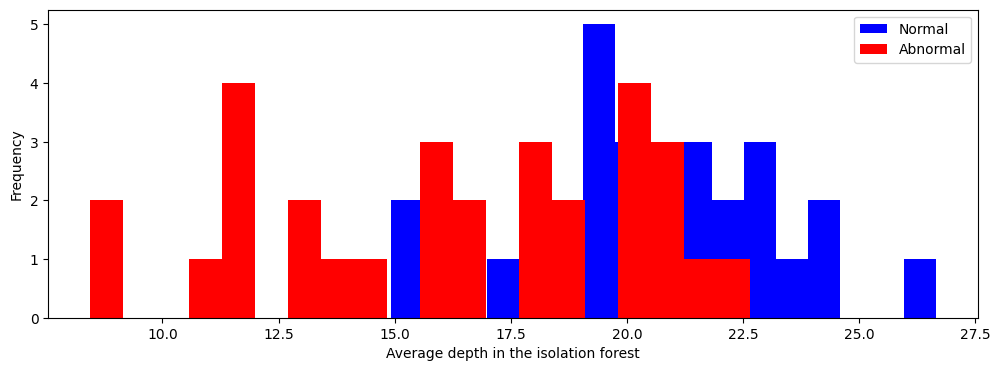

In [116]:
# LEAVE AS-IS

plt.figure(figsize=(12,4))
plt.hist(normal_depths, label='Normal', bins=20, density=False, color='blue')
plt.hist(abnormal_depths, label='Abnormal', bins=20, density=False, color='red')
plt.xlabel('Average depth in the isolation forest')
plt.ylabel('Frequency')
plt.legend()
plt.show()

Observing that the average depth of abnormal items is lower than that of normal items, we can infer that items with low depth are likely to be normal. Conversely, items with elevated depth are more likely to be classified as abnormal.

## 3.2. Compute outlier scores and conclude

In [117]:
# LEAVE AS-IS

# Source: https://stackoverflow.com/a/27683292/1235784

from numpy import euler_gamma
from scipy.special import digamma
def harmonic(s):
    return digamma(s + 1) + euler_gamma

In [118]:
# LEAVE AS-IS

def outlier_score_factory():
    n = len(df.index)
    c_n = 2.0 * harmonic(n - 1.0) - (2.0 * (n-1)/n)
    return lambda d: 2.0**(-d/c_n)

outlier_score = outlier_score_factory()

normal_scores = [outlier_score(d) for d in normal_depths]
abnormal_scores = [outlier_score(d) for d in abnormal_depths]

###  Histogram of outlier scores of normal and abnormal items.

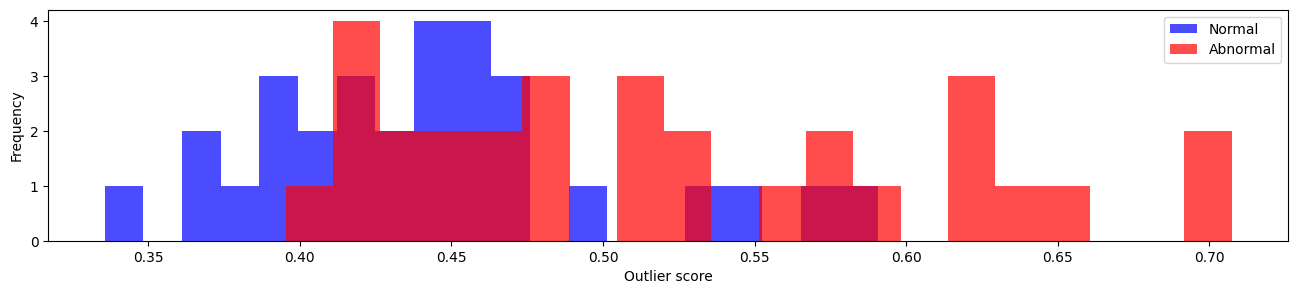

In [119]:
# LEAVE AS-IS

plt.figure(figsize=(16,3))

# Plot the two histograms; the parameter 'alpha' is the transparency of the bar
plt.hist(normal_scores, label='Normal', bins=20, density=False, color='blue', alpha=0.7)
plt.hist(abnormal_scores, label='Abnormal', bins=20, density=False, color='red', alpha=0.7)

# Draw the axis labels, legend, and display
plt.xlabel('Outlier score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

The average outlier score for normal items is consistently lower than the mean outlier score for abnormal items. Therefore, identifying an item with a notably higher outlier score allows us to confidently classify it as abnormal, and conversely, a lower outlier score indicates a high likelihood of normalcy.

### Optimal Treshold

In [120]:
normal = []
abnormal = []
outlier_scores = normal_scores + abnormal_scores
threshold = np.mean(outlier_scores)
#We predict the items classyfing them in the corresponding class based in threshold.
for i in range(len(outlier_scores)):
    if(outlier_scores[i] <= threshold):
        normal.append(outlier_scores[i])
    else:
        abnormal.append(outlier_scores[i])

### Binary Search function

In [121]:
def binary_search(arr, low, high, x):
    #check base case
    if high >= low:
        mid = (high + low) // 2

        #If element is present at the middle itself
        if arr[mid] == x:
            return mid
        #If element is smaller than mid, then it can only be present in left subarray
        elif arr[mid]>x:
            return binary_search(arr, low, mid - 1, x)
        #Else the element can obly be present in right subarray
        else:
            return binary_search(arr, mid + 1, high, x)
    else:
        #Element is not present in the array
        return -1

### Evaluation of the optimal threshold.

In [122]:
# Evaluate the threshold you have found. We know results will not be perfect as in this dataset there are some normal exams that look like abnormal and viceversa. If you use this threshold, indicate what is the estimated false positive rate (the probability of saying that a thyroid is abnormal when it is normal), and false negative rate (the probability of saying that a thyroid is normal when it is abnormal).

isnormal_normal_threshold = 0 #Is normal and we predict normal
isnormal_abnormal_threshold = 0 #Is normal and we predict abnormal
isabnormal_normal_threshold = 0 #Is abnormal and we predict normal
isabnormal_abnormal_threshold = 0 #Is abnormal and we predict abnormal
#Compute number of times that each thing happens
for i in range(len(normal)):
    if binary_search(normal_scores, 0, len(normal_scores)-1, normal[i]) != -1:
        isnormal_normal_threshold+=1
    else:
        isnormal_abnormal_threshold+=1

for i in range(len(abnormal)):
    if binary_search(abnormal_scores, 0, len(abnormal_scores)-1, abnormal[i]) != -1:
        isabnormal_abnormal_threshold+=1
    else:
        isabnormal_normal_threshold+=1

#Compute false positive rate as the ratio of number of abnormal items predicted that were not abnormal
#Compute false negative rate as the ratio of number of normal items predicted that were not normal
false_positive_rate = isnormal_abnormal_threshold/ (isnormal_abnormal_threshold + isnormal_normal_threshold)
false_negative_rate = isabnormal_normal_threshold/ (isabnormal_normal_threshold + isabnormal_abnormal_threshold)
print("false_positive_rate: ", false_positive_rate)
print("false_negative_rate: ", false_negative_rate)

false_positive_rate:  0.8648648648648649
false_negative_rate:  0.782608695652174


The analysis of the obtained results reveals a false positive rate of approximately 86.5%, indicating that a significant portion of items predicted as abnormal are, in fact, not abnormal. Conversely, the false negative rate is around 78.3%, signifying that the model is missing a considerable number of truly abnormal cases. The model appears to be more inclined towards false positives than false negatives. Depending on the application, adjustments to the model or its threshold may be needed to achieve a better balance between these types of errors.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>